# Elizabeth Daly
# HDip Data Analytics 2020
## Machine Learning & Statistics Project
***

For the module project we must create a web service that uses machine learning to make predictions of wind turbine power output from wind speed values. The web service should respond with predicted power values based on wind speed values sent as HTTP requests. A Dockerfile will be used to build and run the web service in a container. 

The very first thing to do is to import required packages.

In [1]:
# For data frames.
import pandas as pd

# For numerical arrays.
import numpy as np

# For plotting
import matplotlib.pyplot as plt

#For maths
import math as m

# Might use this
import seaborn as sns

## Data exploration
Import the **powerproduction** dataset provided and have a look at it.

In [2]:
# File provided as a txt file. I saved it as a csv file.
df = pd.read_csv("data\powerproduction.csv")

# Size?
shape = df.shape
print("Data frame shape", shape, "r,c")

# Check for NaNs, missing values etc
print(df.count())

Data frame shape (500, 2) r,c
speed    500
power    500
dtype: int64


In [3]:
df

,speed,power
0,0.000,0.0
1,0.125,0.0
2,0.150,0.0
3,0.225,0.0
4,0.275,0.0
...,...,...
495,24.775,0.0
496,24.850,0.0
497,24.875,0.0
498,24.950,0.0


The raw data contains a column of wind speed values (in increasing order of wind speed) and a column of associated power values. Looks like the first and last 5 lines contain zeros for power. Is this just a fluke? There's probably a reason for it: one can't generate power with low wind speeds and perhaps one can't operate the turbines at very high wind speeds? Check by printing more of the head of file. No units have been provided with the data, so I will assume units of wind speed are (m/s), and those of power are kilowatts (kW), as that's what seems to make sense for these numbers.

In [4]:
df.head(10)

,speed,power
0,0.000,0.000
1,0.125,0.000
2,0.150,0.000
3,0.225,0.000
4,0.275,0.000
5,0.325,4.331
6,0.400,5.186
7,0.450,3.826
8,0.501,1.048
9,0.526,5.553


In [5]:
# Look at some quick descriptive statistics of the numeric data.
print(df.describe())

            speed       power
count  500.000000  500.000000
mean    12.590398   48.014584
std      7.224991   41.614572
min      0.000000    0.000000
25%      6.324750    5.288000
50%     12.550500   41.645500
75%     18.775250   93.537000
max     25.000000  113.556000


Look at the distribution of wind speeds. Why? Our assignment in the Programming for Data Analysis module involved looking at the numpy.random package <span style='color:red'> [np random] </span>. I learned that under certain conditions, wind speed has a Rayleigh distribution, which is not symmetrical. I wonder if the samples in our dataset follow a such distribution? The mean and variance of this distribution are calculated from the scale factor: $\mu = \sqrt{\pi / 2} s$ and $\sigma^2 = (4 - \pi)/2 s^2$. This results in $\mu \approx 1.25 s$ and $\sigma^2 \approx 0.43 s$. From the descriptive statistics above we know that the mean wind speed is 12.6 m/s, so the scale factor to use is $s = \mu/1.25 \approx 10$.

Average wind speed is 12.59 m/s


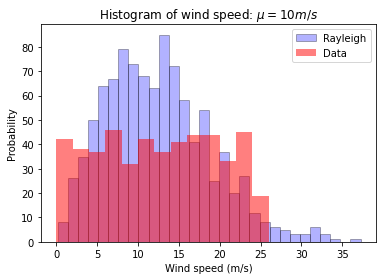

In [6]:
# Wind speeds sampled from a Rayleigh distribution, mean=12.6 m/s
# Default: numpy.random.rayleigh(scale=1.0, size=None)
data = np.random.rayleigh(10, 1000) 
plt.hist(data, bins=30, alpha = 0.3, facecolor='blue', edgecolor='black', label=['Rayleigh'])

bins = np.arange(0, 30, 2) # fixed bin size
plt.hist(df['speed'], bins=bins, alpha=0.5, facecolor='red', label=['Data'])

plt.xlabel('Wind speed (m/s)')
plt.ylabel('Probability')
plt.title('Histogram of wind speed: $\mu=10 m/s$')
plt.legend()
w = df['speed'].mean(axis=0)
print(f'Average wind speed is {w:.2f} m/s')

Well, that was a dead end. Clearly the wind speeds provided do not follow a Rayleigh distribution, rather roughly a uniform distribution.

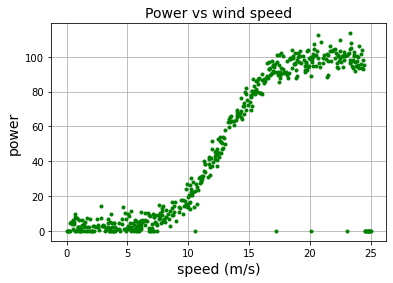

In [7]:
# Try plotting power as a function of wind speed to check for any obvious relationship between them.
plt.plot(df['speed'], df['power'],  '.g')
plt.title('Power vs wind speed', fontsize='14')
plt.xlabel('speed (m/s)', fontsize='14')
plt.ylabel('power', fontsize='14')
plt.grid()

Clearly there isn't a simple relationship (like a linear one) between power and speed. It looks as if little power is generated until some threshold speed is achieved (about 7 m/s), then it increases nearly linearly in a range of wind speeds (10 - 15 m/s), before saturating above a certain wind speed (about 17 m/s). The plot would suggest there is a range of wind speeds where the power seems to increase linearly with wind speed, but we need to consider a model that works outside of this range also. Apart from the zero power values at the top and bottom (more here) of the dataset, there are very occasional zero values for power above about 10 m/s; to me they just look like anomalies.

## What do we expect?
Is this the curve we should expect? I think so. The theoretical power curve for a turbine is specific to each turbine and site; see Figure 2 in <span style='color:red'> [WT curve] </span>. I'll include a screengrab here. On the figure:
- The cut-in speed is the threshold wind speed that much be reached before the turbine will start to generate electricity. A typical value is about 3 m/s.
- The rated output power is achieved at approximately 12 - 13 m/s.
- The cut-out speed is the wind speed at which the turbine will stop producing electricity in order to avoid damage; typically 25 m/s.

<img src="img/P-wind-theory.JPG" height=500 width=500>

How is this theoretical curve calculated? I found some formulae in <span style='color:red'> [WT calc] </span> which state that the extractable power from the wind is given by:
$$P = \frac{1}{2} \rho A v^3 C_p$$
where $\rho$ is the density of air, $A$ is the area swept by the turbines, $v$ is the wind speed, and $C_p$ is the power coefficient. Looking at this formula I would expect power to depend on $v^3$. However, $C_p$ is not static as it depends on the ratio of blade tip speed to wind speed (called $\lambda$). That function looks like this:

<img src="img/Cp-lambda.JPG">

Average wind speed in data is 12.59 m/s


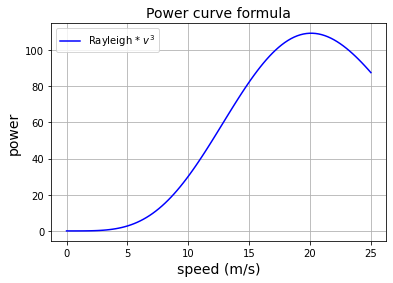

In [8]:
# So I would expect the power curve to be a product of $v^3$ and this bump above. I'll try to model it.
# wind speed
x = np.linspace(0, 25, 100)

# speed ^3
v = np.power(x, 3)

# Try a Rayeigh distribution for the power coefficient, need scale factor sc.
# w = mean wind speed from our dataset above
print(f'Average wind speed in data is {w:.2f} m/s')

sc = w / (m.sqrt((m.pi) / 2)) # mode or scale
ray = lambda s, x: (x / s ** 2) * ( np.exp( (-x **2) / (2 * s **2) )  )

# PLot the product v^3 * Rayleigh and scale it down.
plt.plot(x, 0.5 * ray(sc, x)*v, color='b', label='Rayleigh * $v^3$')
plt.title('Power curve formula', fontsize='14')
plt.xlabel('speed (m/s)', fontsize='14')
plt.ylabel('power', fontsize='14')
plt.legend()
plt.grid()

 So this is starting to look like our data but I feel it would be difficult to model. I might start with something simpler.

### Data cleaning
First thing I'll do is clean the dataset. The easiest thing to do would be to remove all rows where power = 0. I don't really want to do that because I feel like the zero power values below about 10 m/s are part of the data, while the ones above about 24 m/s represent some sort of a limit of operation. I can't see how a model would be able to abruptly predict power = 0 at the very high end of speed values unless I hard coded it in as a condition, or constrain the allowed input speed values to a range. So I might come back to this.

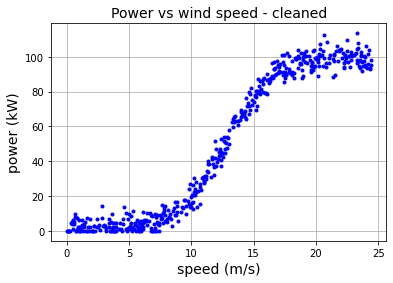

In [9]:
# Where do all the zeros occur?
dfz = df[df["power"] == 0]
# print(f'There are {dfz.shape} zero values for power')
# print(dfz)

# Want to keep all rows with power != 0 iff speed > 10
# https://www.shanelynn.ie/select-pandas-dataframe-rows-and-columns-using-iloc-loc-and-ix/
dfc = df.loc[(df.power == 0) & (df.speed > 10)] # indices where this is true
dfc # check 14 rows
# I want to remove these rows from my existing dataset.
df.drop(df.loc[(df.power == 0) & (df.speed > 10)].index, inplace=True)

plt.plot(df['speed'], df['power'],  '.b')
plt.title('Power vs wind speed - cleaned', fontsize='14')
plt.xlabel('speed (m/s)', fontsize='14')
plt.ylabel('power (kW)', fontsize='14')
plt.grid()

## Procedure
<span style='color:red'> [Geron] </span> and <span style='color:red'> [CourseML] </span>

## References
<span style='color:red'> [Geron] </span> Aurelien Geron, *Hands-on Machine Learning with Scikit-Learn, Keras & TensorFlow*, **2019**, 2nd Edition, O'Reilly Media, Inc., CA

<span style='color:red'> [CourseML] </span> Andrew Ng, Coursera Machine Learning offered by Stanford, https://www.coursera.org/learn/machine-learning, (Completed & certified Sept. 2020). 

<span style='color:red'> [np random] </span> numpy.random.rayleigh, NumPy v1.19 Manual, https://numpy.org/doc/stable/reference/random/generated/numpy.random.rayleigh.html

<span style='color:red'> [WT FAQ] </span> Wind Turbine FAQ, ENERPOWER Total Energy Solutions, https://enerpower.ie/portfolio/wind-turbine-faq-ireland/, (Accessed 21 Oct. 2020).

<span style='color:red'> [WT calc] </span> Wind Turbine Power Calculations, RWE npower renewables, https://docplayer.net/17802133-Wind-turbine-power-calculations.html, (Accessed 21 Oct. 2020).

<span style='color:red'> [WT curve] </span> Wind Energy Basics, New York Wind Energy Guide for Local Decision Makers, www.nyserda.ny.gov/-/media/Files/Publications/Research/Biomass-Solar-Wind/NY-Wind-Energy-Guide-1.pdf, (Accessed 9 Nov. 2020).

<span style='color:red'> [] </span>


Notes:
- describe power curve
- supervised learning as have training set
- feature selection, only one here
- what about feature scaling etc
- algs to use for this problem?
- how to measure perf? Test & validation. 